In [26]:
import os
import io
import base64

import rasterio
import numpy as np
import matplotlib.pyplot as plt

In [8]:
CWD = os.getcwd()
PATH_TO_DTMS = os.path.join(CWD, "data/processed/dtm")

files = os.listdir(PATH_TO_DTMS)
# print(files)
for index in range(len(files)):
    files[index] = os.path.join(PATH_TO_DTMS, files[index])

# for file in files:
#     print(os.path.exists(file))

In [53]:
# FILENAME = "ANA_A01_2017_laz_0_generate_dtm.tif"
FILENAME = "ANA_A01_2017_laz_0_fnands.tif"
PATH_TO_FILE = os.path.join(PATH_TO_DTMS, FILENAME)

print(os.path.exists(PATH_TO_FILE))

True


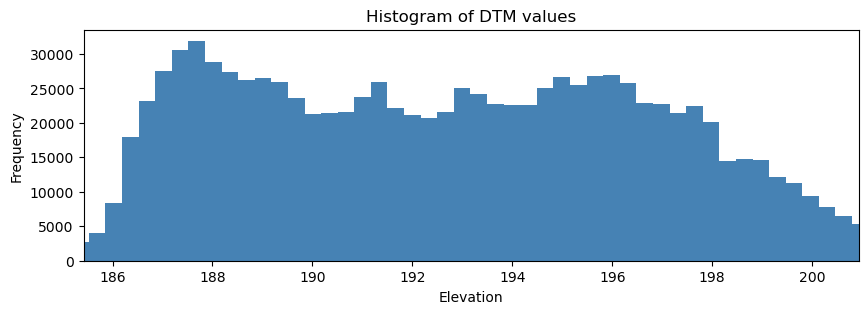

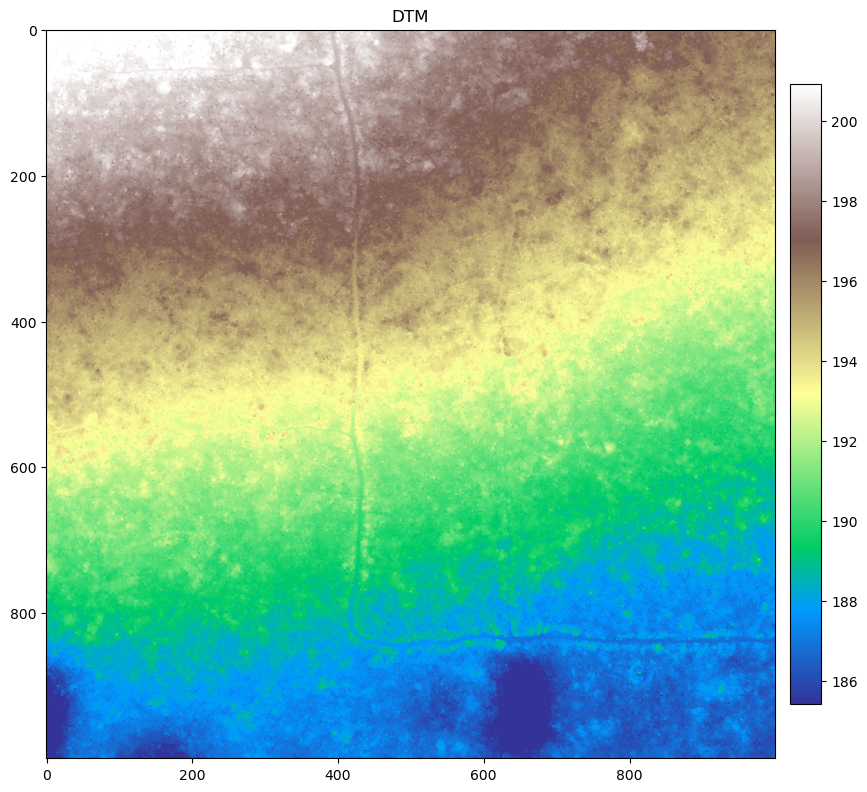

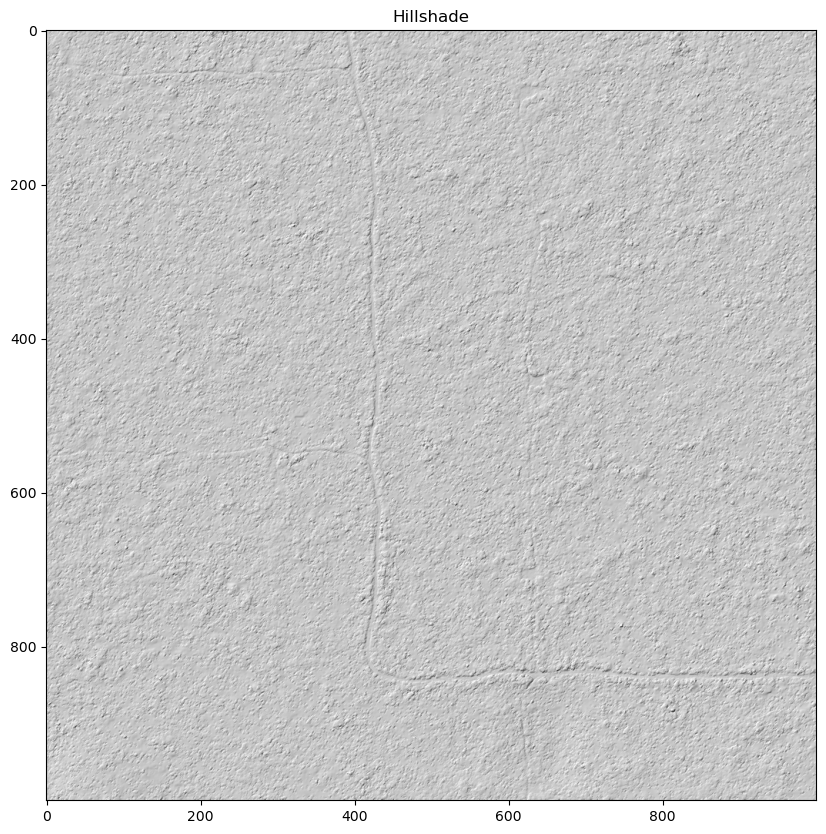

In [54]:
def hillshade(array, azimuth, angle_altitude):
    """Returns hillshade image from elevation array."""
    azimuth = 360.0 - azimuth
    x, y = np.gradient(array)
    slope = np.pi / 2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azm_rad = azimuth * np.pi / 180.
    alt_rad = angle_altitude * np.pi / 180.
    shaded = np.sin(alt_rad) * np.sin(slope) + \
             np.cos(alt_rad) * np.cos(slope) * \
             np.cos((azm_rad - np.pi/2.) - aspect)
    result = 255 * (shaded + 1) / 2
    return np.clip(result, 0, 255)

def plot_dtm_and_hillshade(dem, hs, vmin, vmax):

    # Histogram
    plt.figure(figsize=(10, 3))
    plt.hist(dem[np.isfinite(dem)], bins=60, color='steelblue')
    plt.title('Histogram of DTM values')
    plt.xlabel('Elevation')
    plt.ylabel('Frequency')
    plt.xlim([vmin, vmax])
    plt.show()

    # DTM
    plt.figure(figsize=(10, 10))
    plt.imshow(dem, cmap='terrain', vmin=vmin, vmax=vmax)
    plt.title('DTM')
    plt.colorbar(fraction=0.04, pad=0.02)
    plt.show()

    # Hillshade
    plt.figure(figsize=(10, 10))
    plt.imshow(hs, cmap='gray')
    plt.title('Hillshade')
    plt.show()

def process_dtm_tile_array(dtm_path):
    with rasterio.open(dtm_path) as src:
        dem = src.read(1)
        # Mask nodata or very low/very high values
        nodata = src.nodata
        dem = np.where((dem == nodata) | (dem < -100) | (dem > 9999), np.nan, dem)
        vmin = np.nanpercentile(dem, 1)
        vmax = np.nanpercentile(dem, 99)
        # Fill missing values for hillshade
        dem_filled = np.nan_to_num(dem, nan=np.nanmean(dem))
        hs = hillshade(dem_filled, azimuth=315, angle_altitude=45)
        # Plot arrays, colorbar and histogram
        plot_dtm_and_hillshade(dem, hs, vmin, vmax)
    return dem, hs

# --- RUN HERE ---
# Make sure to set your file path!
dem, hs = process_dtm_tile_array(PATH_TO_FILE)